In [67]:
import graphviz
import pandas as pd
import numpy as np
import tflscripts
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results_filtered.p')

In [68]:
df = df.loc[df.source_device_type == 'Mite']
df = df.loc[df.target_device_type == 'Mite']
# df = df.loc[df.accuracy_negative >= 0.95]
# df = df.loc[df.accuracy_positive >= 0.85]

df = df.loc[df.features_name == 'All']
df = df.loc[df.classifier == 'LogisticRegression']
df = df[['source_placement', 'target_placement', 'source_room', 'target_room', 'label', 'accuracy']]
df = df.sort_values(by='accuracy', ascending=False)
df = df.drop_duplicates(df.columns.difference(['accuracy']))

df = df.loc[(df.source_room != 'robotics') & (df.target_room != 'robotics')]
df['accuracy'] = df['accuracy'].round(2)

len(df)

527

In [70]:
def key_for(room, placement):
    return ''.join([room[0:2], placement[0]])

In [71]:
df['source'] = [key_for(r['source_room'], r['source_placement']) for _, r in df.iterrows()]
df['target'] = [key_for(r['target_room'], r['target_placement']) for _, r in df.iterrows()]

In [72]:
df_without_transfer = df.loc[df.source == df.target]
df_transfers = df.loc[df.source != df.target]

In [95]:
colors = {'Coffee': 'rosybrown1', 'Sink': 'moccasin', 'Table': 'grey80', 'Pantry': 'palegreen3', 'Left': 'turquoise', 'Right': 'powderblue', 'E': 'grey40', 'O': 'lightsalmon2', 'I': 'tan'}
shapes = {'robotics': 'box', 'synergy': 'ellipse', 'scott': 'diamond'}

def get_transfer_counts(activity):
    filtered = df_transfers.loc[df_transfers.label == activity]

    transfer_counts = filtered[['source', 'target', 'source_dataset']].groupby(['source', 'target']).agg(['count']).reset_index()
    transfer_counts.columns = ['source', 'target', 'count']

    return transfer_counts

def graph(activity):
    subdf_transfers = df_transfers.loc[df_transfers.label == activity]
    subdf_without_transfer = df_without_transfer.loc[df_without_transfer.label == activity]

    d = graphviz.Digraph()

    clusters = {}
    for space in subdf_transfers.source_room.unique():
        c = graphviz.Digraph('cluster_' + space)
        c.body.append('style=filled')
        c.body.append('color=lightgrey')
        # c.body.append('label=process')
        c.node_attr.update(style='filled', color='white')
        clusters[space] = c

    for _, row in subdf_without_transfer.iterrows():
        c = clusters[row['source_room']]
        c.node(row['source'],
               str(row['accuracy']),
               style='filled', fillcolor=colors[row['source_placement']], shape=shapes[row['source_room']])

    skip = {}
    for _, row in subdf_transfers.iterrows():
        if row['source_room'] == row['target_room']:
            continue
        constraint = str(row['source_room'] != row['target_room'])
        d.edge(row['source'], row['target'], style='tapered', arrowhead='none',
               penwidth='2',
               constraint=constraint)

#         n1_to_n2 = aggr_transfer_counts.loc[(aggr_transfer_counts.source == n1) & (aggr_transfer_counts.target == n2)]
#         n2_to_n1 = aggr_transfer_counts.loc[(aggr_transfer_counts.source == n2) & (aggr_transfer_counts.target == n1)]

#         constraint = str(n1[0] == n2[0])

#         if len(n1_to_n2) > 0 and len(n2_to_n1) > 0:
#             d.edge(n1, n2, dir='both', arrowhead='vee', arrowtail='vee', constraint=constraint)
#         elif len(n1_to_n2) > 0:
#             d.edge(n1, n2, style='dotted', arrowhead='vee', constraint=constraint)
#         elif len(n2_to_n1) > 0:
#             d.edge(n2, n1, style='dotted', arrowhead='vee', constraint=constraint)

    # c.edges([built_edges])
    for space in clusters:
        d.subgraph(clusters[space])

    print(activity)
    return d

Chopping food


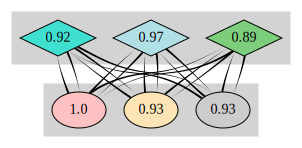

In [96]:
graph('Chopping food')

Dishes


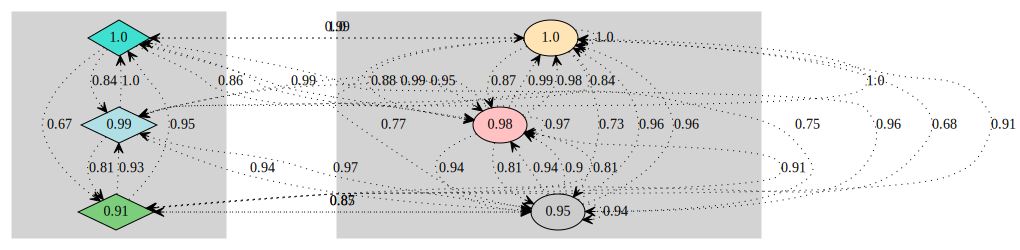

In [61]:
d = graph('Dishes')
d.render('plots/dishes_transfer_graph.gv', view=True)
d

Microwave


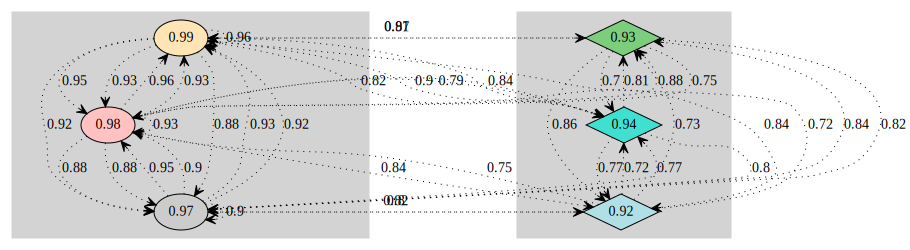

In [63]:
d = graph('Microwave')
d.render('plots/microwave_transfer_graph.gv', view=True)
d

Alarm


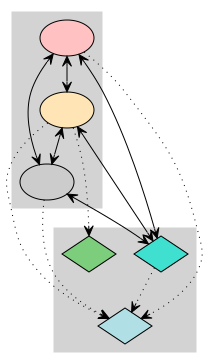

In [14]:
graph('Alarm')

Kettle


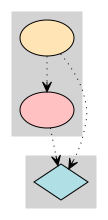

In [12]:
graph('Kettle')

Microwave button press


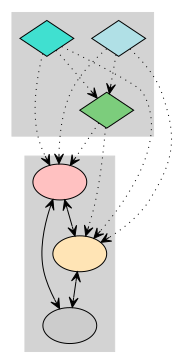

In [25]:
graph('Microwave button press')